In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%config Completer.use_jedi = False

In [3]:
import sys, os
sys.path.append('/home/andy/Documents/software')
import getdata, sqlutilpy

import numpy as np, healpy as hp, h5py, pandas as pd
from scipy import stats, special, linalg, optimize
import scipy
import tqdm

# Plotting modules
import matplotlib.pyplot as plt, matplotlib
import matplotlib
from pylab import cm
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('axes', labelsize=16)
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.rc('legend',fontsize=16)
plt.rc('font',size=16)

In [4]:
import warnings
warnings.filterwarnings("ignore", message="You are modifying the state of a globally registered colormap.")
warnings.filterwarnings("ignore", message="Passing parameters norm and vmin/vmax simultaneously is deprecated")
warnings.filterwarnings("ignore", message="divide by zero encountered")
warnings.filterwarnings("ignore", message="overflow encountered in exp")

In [5]:
def add_log_cbar(ax, vmin=0., vmax=1., cmap='viridis',
             orientation='vertical', ticks=[0,1], tick_labels=['0','1']):

    norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
    im = plt.cm.ScalarMappable(norm=norm, cmap=cmap); im.set_array([])

    tick_pos = (np.log(np.array(ticks)) - np.log(vmin))/(np.log(vmax)-np.log(vmin))
    cbar = plt.colorbar(im, cax=ax, orientation=orientation, ticks=tick_pos)

    if orientation=='vertical':
        cbar.ax.set_yticklabels(tick_labels)
    else:
        cbar.ax.set_xticklabels(tick_labels)
    #print(tick_pos, tick_labels)

    return cbar

In [6]:
from astropy.coordinates import SkyCoord
import warnings
warnings.filterwarnings('ignore')

## CSV  file

In [7]:
gums_sample = pd.read_csv('/data/asfe2/Projects/mwtrace_data/gums/gums_north_b80.csv').to_dict('list')

for key in gums_sample.keys():
    gums_sample[key] = np.array(gums_sample[key])

In [19]:
gums_sample['mag_v'] = gums_sample['mean_absolute_v'] + 10 + 5*np.log10(gums_sample['barycentric_distance']/1e3)

In [83]:
include = [sei[17] in [' '] for sei in gums_sample['source_extended_id']]

In [68]:
gums_sample['mag_g'][include&(gums_sample['mag_g']>21.1)]

array([21.278484, 21.117977, 21.207094, 21.110882])

In [69]:
gums_sample['source_id'][include&(gums_sample['mag_g']>21.1)]

array([1891960827565572097, 1891922091255529473, 1747469211376025601,
       1748215041036910593])

In [81]:
gums_sample.keys()

dict_keys(['source_extended_id', 'source_id', 'ra', 'dec', 'barycentric_distance', 'mag_g', 'v_i', 'mean_absolute_v', 'mag_bp', 'mag_rp', 'mag_rvs', 'mag_v'])

In [86]:
from astropy.coordinates import SkyCoord
SkyCoord(ra=gums_sample['ra'][include&(gums_sample['mag_g']>21.1)], 
         dec=gums_sample['dec'][include&(gums_sample['mag_g']>21.1)],
         unit='deg', frame='icrs').galactic

<SkyCoord (Galactic): (l, b) in deg
    [(153.76907075, -86.89622689), (253.85675021, -84.49753876),
     ( 30.02888769, -80.37883124), (114.42063764, -86.49768976),
     (316.31801876, -80.63130866), (116.4193106 , -84.17364676),
     (329.9478856 , -85.74659902), (309.99603149, -84.164437  ),
     (129.37135847, -81.04642379), (283.70643505, -83.50268391),
     ( 59.13122983, -87.81709523), (295.51883079, -84.54681921),
     ( 32.26929817, -83.75708169), (196.02524127, -80.61977659),
     (291.01020576, -88.74872969), (297.43011823, -83.27637728),
     ( 86.31434749, -86.14129408), (308.45745703, -80.03633474),
     ( 55.79099204, -81.31972706), ( 19.17638204, -86.95895219),
     ( 85.44199242, -87.04254315), (198.65036842, -85.20413497),
     (120.15252648, -80.1800951 ), ( 25.19886683, -83.79732115),
     ( 41.76878981, -84.54661189), (277.06133674, -87.16958769),
     (322.87857272, -86.98846196), ( 22.73167501, -81.3396348 ),
     (283.46952659, -84.50385385), (120.39826435, -81.

In [70]:
gums_sample['source_extended_id'][include&(gums_sample['mag_g']>21.1)]

array(['*172071001-000001+     ', '*172061982-000001+     ',
       '*138428925-000001+     ', '*138602577-000001+     '], dtype='<U23')

In [71]:
in_system = [sei[:17]=='*172071001-000001' for sei in gums_sample['source_extended_id']]

In [78]:
gums_sample['mag_g'][in_system]

array([21.333979, 24.534773, 21.278484])

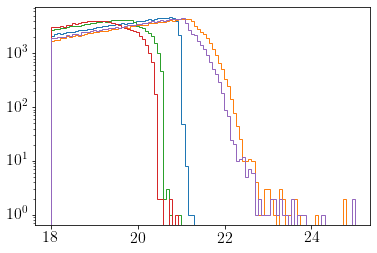

In [39]:
plt.hist(gums_sample['mag_g'][include], bins=100, range=[18,25], histtype='step');
plt.hist(gums_sample['mag_bp'][include], bins=100, range=[18,25], histtype='step');
plt.hist(gums_sample['mag_rp'][include], bins=100, range=[18,25], histtype='step');
plt.hist(gums_sample['mag_rvs'][include], bins=100, range=[18,25], histtype='step');
plt.hist(gums_sample['mag_v'][include], bins=100, range=[18,25], histtype='step');

plt.yscale('log')

In [9]:
gums_sample['abs_g'] = gums_sample['mag_g'] - 10 - 5*np.log10(gums_sample['barycentric_distance']/1e3)
gums_sample['abs_g'] = gums_sample['mag_g'] - 10 - 5*np.log10(gums_sample['barycentric_distance']/1e3)
gums_sample['abs_g'] = gums_sample['mag_g'] - 10 - 5*np.log10(gums_sample['barycentric_distance']/1e3)
gums_sample['abs_g'] = gums_sample['mag_g'] - 10 - 5*np.log10(gums_sample['barycentric_distance']/1e3)

gums_sample['mag_v'] = gums_sample['mean_absolute_v'] + 10 + 5*np.log10(gums_sample['barycentric_distance']/1e3)

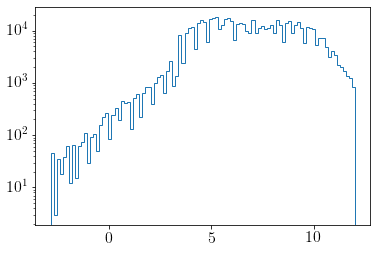

In [10]:
plt.hist(gums_sample['abs_g'][(gums_sample['abs_g']<12)&include], bins=100, histtype='step');
plt.yscale('log')

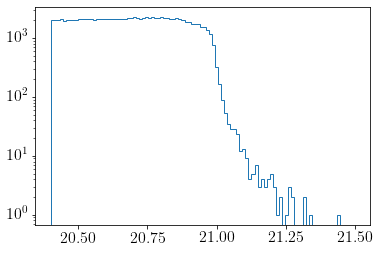

In [16]:
plt.hist(gums_sample['mag_g'][include], bins=100, range=[20.4,21.5], histtype='step');
# plt.hist(gums_sample['mag_bp'][include], bins=100, range=[18,25], histtype='step');
# plt.hist(gums_sample['mag_rp'][include], bins=100, range=[18,25], histtype='step');
# plt.hist(gums_sample['mag_rvs'][include], bins=100, range=[18,25], histtype='step');
plt.yscale('log')

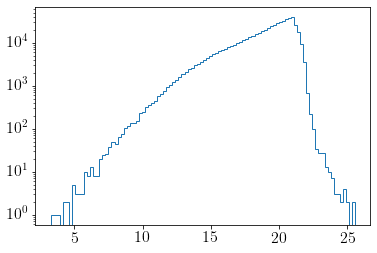

In [131]:
plt.hist(gums_sample['mag_v'][include], bins=100, histtype='step');
plt.yscale('log')

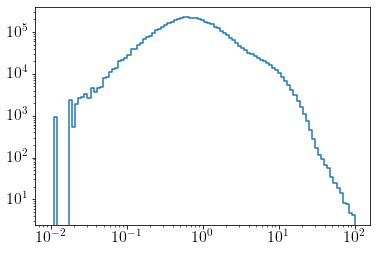

In [94]:
bins = np.logspace(-2,2,100)
hist, bins = np.histogram(gums_sample['barycentric_distance'][include]/1e3, bins=bins)
x = np.repeat(bins,2)
y = np.insert(np.repeat(hist/(bins[1:]-bins[:-1]), 2), (0,2*len(hist)), (0,0))
plt.plot(x,y)
plt.yscale('log'); plt.xscale('log')

In [67]:
indicator = []; 
for sei in tqdm.tqdm_notebook(gums_sample['source_extended_id'], total=len(gums_sample['source_id'])):
    indicator.append(sei[17])
    
include = [i in [' ','V','+'] for i in indicator]

  0%|          | 0/1087819 [00:00<?, ?it/s]

### hdf5 file

In [8]:
gums_sample = {}
with h5py.File('/data/asfe2/Projects/mwtrace_data/gums/gums_north_b80.h', 'r') as hf:
    for key in hf['sample'].keys():
        gums_sample[key] = hf['sample'][key][...]

In [9]:
for key in ['m','s','sinb','l']:
    print(key, np.min(gums_sample[key]), np.max(gums_sample[key]))

m 2.8614514 21.31435
s 0.0056085760000000005 99.92219
sinb 0.9848077747968468 0.9999999891432805
l 0.0010024615461032775 359.99889398363973


In [10]:
for key in ['m','s','sinb','l']:
    print(key, np.min(gums_sample[key]), np.max(gums_sample[key]))

m 2.8614514 21.31435
s 0.0056085760000000005 99.92219
sinb 0.9848077747968468 0.9999999891432805
l 0.0010024615461032775 359.99889398363973


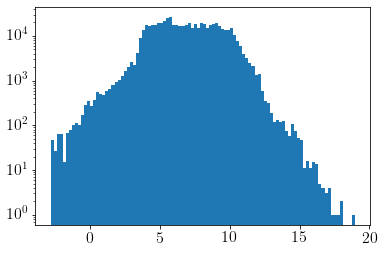

In [8]:
plt.hist(gums_sample['M'], bins=100);
plt.yscale('log')

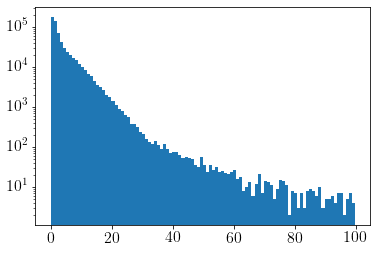

In [17]:
plt.hist(gums_sample['s'], bins=100);
plt.yscale('log')

In [41]:
gums_sample['source_extended_id'][:10]

array(['*205532784-000001A     ', '*205532784-000001B     ',
       '*205532784-000001+     ', '*205532785-000001      ',
       '*205556069-000001A     ', '*205556069-000001B     ',
       '*205556069-000001C     ', '*205730690-000001+     ',
       '*205556069-000001+     ', '*205567709-000001      '], dtype='<U23')

In [49]:
mags = []
for indicator in ['+','A','B','C']:
    mags.append(gums_sample['mag_g'][gums_sample['source_extended_id'] == f'*205556069-000001{indicator}     '])

In [55]:
-2.5*np.log10(np.sum( 10**(-np.array(mags)[:,0][1:]/2.5) ))

19.975846821049647

In [45]:
gums_sample['mag_g'][:10]

array([11.829028, 27.216654, 11.829027, 19.897343, 20.219524, 25.948387,
       21.73996 , 12.95395 , 19.975847, 18.913826])

In [47]:
-2.5*np.log10( 10**(-11.829028/2.5) + 10**(-27.216654/2.5) )

11.829027240244647

In [42]:
gums_sample['barycentric_distance'][:10]

array([ 360.22156,  360.22156,  360.22156, 2186.065  , 9571.839  ,
       9571.838  , 9571.845  ,  781.5243 , 9571.841  , 2093.3252 ])

In [7]:
file = "gaia_unwise_sdss_b80"
filename="/data/asfe2/Projects/mwtrace_data/gaia/%s.h" % file
size = 'full'
# Load Sample
#keys = {'phot_g_mean_mag':'phot_g_mean_mag', 'parallax':'parallax', 'b':'b', 'parallax_error':'parallax_error', }
keys = ['source_id', 'phot_g_mean_mag', 'phot_g_corr', 'parallax','l', 'b', 'parallax_error', 'parallax_error_corr', 'zeropoint',
        'specobjid', 'class', 'bp_rp', 'phot_bp_rp_excess_factor', 'phot_bp_rp_excess_factor_c', 'w1', 'w2', 'ruwe']
sample = {};
for cardinal in ['south', 'north']:
    sample[cardinal]={}
    with h5py.File(filename, 'r') as hf:
        subset = ( ~np.isnan(hf[cardinal]['phot_g_corr'][...]) )
        subset = np.ones(len(hf[cardinal]['source_id']), dtype=bool)
        print('%d/%d' % (np.sum(subset), len(subset)))
        if size=='full': subsample = np.arange(np.sum(subset))
        else: subsample  = np.sort(np.random.choice(np.arange(np.sum(subset)), size=size, replace=False))
        for key in keys:
            sample[cardinal][key]=hf[cardinal][key][...][subset][subsample]
    sample[cardinal]['sinb'] = np.sin(np.deg2rad(sample[cardinal]['b']))
    sample[cardinal]['parallax_obs'] = sample[cardinal]['parallax']-sample[cardinal]['zeropoint']
    sample[cardinal]['m']  = sample[cardinal]['phot_g_corr'].copy()
    
    sample[cardinal]['M'] = sample[cardinal]['m'] + 5*(np.log10(sample[cardinal]['parallax_obs'])-2)

942006/942006
905216/905216


In [8]:
excess_c = {}
with h5py.File(filename, 'r') as hf:
    for cardinal in ['south', 'north']:
        excess_c[cardinal]=hf[cardinal]['phot_bp_rp_excess_factor_c'][...]